In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from src import models, data
from tqdm.auto import tqdm
import json
import os
import numpy as np
import copy

os.makedirs("layer_sweep/Jacobian_plots", exist_ok=True)
os.makedirs("layer_sweep/weights_and_biases", exist_ok=True)

In [3]:
device = "cuda:0"
mt = models.load_model("gptj", device=device)
print(
    f"dtype: {mt.model.dtype}, device: {mt.model.device}, memory: {mt.model.get_memory_footprint()}"
)

dtype: torch.float16, device: cuda:0, memory: 12219206136


In [4]:
# dataset = data.load_dataset()
# capital_cities =[d for d in dataset if d.name == "capital city"][0]
# print(capital_cities)
# # capital_cities.__dict__.keys()
# len(capital_cities.samples)

In [5]:
# indices = np.random.choice(range(len(capital_cities.samples)), 3, replace=False)
# samples = [capital_cities.samples[i] for i in indices]

# training_samples = copy.deepcopy(capital_cities.__dict__)
# training_samples["samples"] = samples
# training_samples = data.Relation(**training_samples)

# training_samples.samples

In [6]:
# from src.operators import JacobianIclMeanEstimator

# mean_estimator = JacobianIclMeanEstimator(
#     mt=mt,
#     h_layer=12,
#     bias_scale_factor=0.2       # so that the bias doesn't knock out the prediction too much in the direction of training examples
# ) 

# operator = mean_estimator(training_samples)
# operator("United States", k = 10).predictions

In [7]:
# from src.data import RelationDataset
# from src.benchmarks import reconstruction, faithfulness

In [8]:
# faith_result = faithfulness(
#     estimator=mean_estimator,
#     dataset = RelationDataset([capital_cities]),
#     n_train=3,
#     n_trials=5,
#     k=3
# )

In [9]:
# for k, v in faith_result.metrics.__dict__.items():
#     print(f"{k}: {v}")

In [10]:
# recos_result = reconstruction(
#     estimator=mean_estimator,
#     dataset = RelationDataset([capital_cities]),
#     n_train=3,
#     n_trials=5,
# )

In [13]:
from src.utils.layer_selection import interpret_logits, logit_lens
from src.utils.supplimentary import untuple

prompt = "The Space Needle is located in the city of"
tokenized = mt.tokenizer(prompt, return_tensors="pt", padding=True).to(mt.model.device)

import baukit

with baukit.TraceDict(
    mt.model,
    models.determine_layer_paths(mt)
) as traces:
    output = mt.model(**tokenized)
    
interpret_logits(mt, output.logits[0][-1])

[(' Seattle', 22.562),
 (' Seat', 16.031),
 (' the', 15.961),
 (' Portland', 15.82),
 (' Space', 15.742),
 (' Sea', 15.656),
 (' downtown', 15.594),
 ('\n', 15.461),
 (' Lake', 15.234),
 (' Bellev', 15.117)]

In [14]:
interested_words = [" Seattle", " Paris", " Dhaka"]
int_tokenized = mt.tokenizer(interested_words, return_tensors="pt", padding=True).to(
    mt.model.device
)
int_tokenized.input_ids

z = untuple(traces[models.determine_layer_paths(mt)[-1]].output)[0][-1]
print(z.shape)

logit_lens(mt, z, [t[0] for t in int_tokenized.input_ids], get_proba=False)

torch.Size([4096])


([(' Seattle', 22.547),
  (' Seat', 16.031),
  (' the', 15.961),
  (' Portland', 15.828),
  (' Space', 15.75),
  (' Sea', 15.648),
  (' downtown', 15.594),
  ('\n', 15.453),
  (' Lake', 15.242),
  (' Bellev', 15.109)],
 {tensor(7312, device='cuda:0'): (22.546875, ' Seattle'),
  tensor(6342, device='cuda:0'): (10.15625, ' Paris'),
  tensor(20529, device='cuda:0'): (2.04296875, ' Dh')})

In [15]:
from src.functional import predict_next_token

predict_next_token(
    mt = mt, prompt = "The Space Needle is located in the city of", k=10
)

[[PredictedToken(token=' Seattle', prob=0.9855276346206665),
  PredictedToken(token=' Seat', prob=0.0014360942877829075),
  PredictedToken(token=' the', prob=0.0013385870261117816),
  PredictedToken(token=' Portland', prob=0.0011629846412688494),
  PredictedToken(token=' Space', prob=0.0010755849070847034),
  PredictedToken(token=' Sea', prob=0.0009870122885331511),
  PredictedToken(token=' downtown', prob=0.000927212240640074),
  PredictedToken(token='\n', prob=0.0008118941332213581),
  PredictedToken(token=' Lake', prob=0.0006472984096035361),
  PredictedToken(token=' Bellev', prob=0.0005757191102020442)]]

In [74]:
def filter_by_model_knowledge(mt, relation_prompt, relation_samples):
    model_knows = []
    for sample in relation_samples:
        top_prediction = predict_next_token(mt = mt, prompt = relation_prompt.format(sample.subject))[0][0].token
        tick = sample.object.strip().startswith(top_prediction.strip())
        if tick:
            model_knows.append(sample)
    return model_knows

In [75]:
dataset = data.load_dataset()
cur_relation = [d for d in dataset if d.name == "capital city"][0]
print(cur_relation.name, " ==> ", len(cur_relation.samples))

capital city  ==>  24


In [76]:
import numpy as np
from src.functional import make_prompt

icl_indices = np.random.choice(range(len(cur_relation.samples)), 3, replace=False)
icl_samples = [cur_relation.samples[i] for i in icl_indices]

icl_prompt = make_prompt(
    prompt_template = cur_relation.prompt_templates[0],
    subject="{}",
    examples=icl_samples,
)

print(icl_prompt)

The capital city of Saudi Arabia is Riyadh
The capital city of Germany is Berlin
The capital city of Brazil is Bras\u00edlia
The capital city of {} is


In [77]:
model_knows = filter_by_model_knowledge(mt, icl_prompt, cur_relation.samples)
len(model_knows)

24

## Layer Richness based on logit lens

In [82]:
from src.utils.layer_selection import layer_c_measure

# relation_prompt = mt.tokenizer.eos_token + " {} is located in the city of"
# subject = "The Space Needle"
# layer_c_measure(mt, relation_prompt, subject, measure = "contribution", verbose=True)

In [83]:
layer_c_info = {layer: [] for layer in models.determine_layer_paths(mt)}

for sample in tqdm(model_knows):
    cur_richness = layer_c_measure(mt, icl_prompt, sample.subject)
    for layer in models.determine_layer_paths(mt):
        layer_c_info[layer].append(cur_richness[layer])

# with open("layer_sweep/layer_contribution_info.json", "w") as f:
with open("layer_sweep/layer_completeness_info.json", "w") as f:
    json.dump(layer_c_info, f)

for layer in models.determine_layer_paths(mt):
    layer_c_info[layer] = np.array(layer_c_info[layer])

  0%|          | 0/24 [00:00<?, ?it/s]

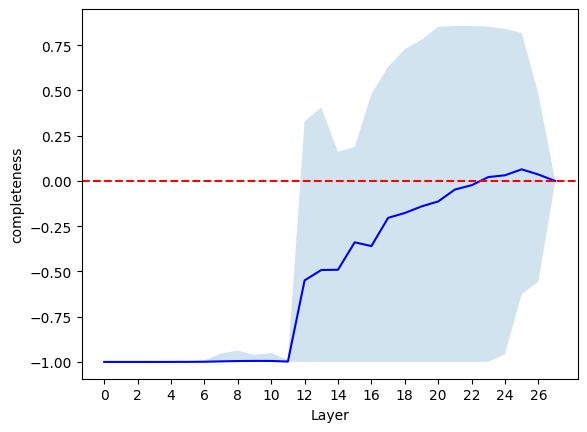

In [84]:
mean_richness = [layer_c_info[layer].mean() for layer in models.determine_layer_paths(mt)]
low_richness = [layer_c_info[layer].min() for layer in models.determine_layer_paths(mt)]
high_richness = [layer_c_info[layer].max() for layer in models.determine_layer_paths(mt)]

plt.plot(mean_richness, color="blue")
plt.fill_between(range(len(mean_richness)), low_richness, high_richness, alpha=0.2)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("completeness")
plt.xticks(range(0, len(mean_richness), 2))

plt.show()

## Layer Richness based on `Jh_norm` and `J_norm`

In [ ]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [ ]:
from src.operators import JacobianEstimator, JacobianIclMeanEstimator
from src.data import RelationSample

# indices = np.random.choice(range(len(capital_cities.samples)), 3, replace=False)
# samples = [capital_cities.samples[i] for i in indices]

# training_samples = copy.deepcopy(capital_cities.__dict__)
# training_samples["samples"] = samples
# training_samples = data.Relation(**training_samples)

# mean_estimator = JacobianIclMeanEstimator(
#     mt=mt,
#     h_layer=12,
# )

# operator = mean_estimator(training_samples)
# operator("Russia", k = 10).predictions

In [ ]:
estimator = JacobianEstimator(
    mt=mt,
    h_layer=12,
)

operator = estimator.call_on_sample(
    sample = RelationSample(subject="United States", object="Washington"),
    prompt_template= icl_prompt
)

In [ ]:
operator.metadata['Jh'].norm().item(), operator.weight.norm().item()

In [ ]:
layerwise_jh = {layer: [] for layer in models.determine_layer_paths(mt)}

for sample in tqdm(set(model_knows) - set(icl_samples)):
    for h_layer in range(0, 24):
        layer_name = models.determine_layer_paths(mt)[h_layer]
        estimator = JacobianEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = estimator.call_on_sample(
            # sample = RelationSample(subject="Russia", object="Moscow"),
            sample = sample,
            prompt_template= icl_prompt
        )

        # print(h_layer, " ===> ", f"J:{operator.weight.norm().item()},  Jh: {operator.misc['Jh'].norm().item()}")
        layerwise_jh[layer_name].append({
            "J": operator.weight.norm().item(),
            "Jh": operator.metadata['Jh'].norm().item(),
            "bias": operator.bias.norm().item()
        })

In [ ]:
for layer in models.determine_layer_paths(mt):
    if layer in layerwise_jh and len(layerwise_jh[layer]) == 0:
        layerwise_jh.pop(layer)

with open("layer_sweep/layer_jh_info.json", "w") as f:
    json.dump(layerwise_jh, f)

In [ ]:
key = "Jh"

info = {
    layer: np.array([layerwise_jh[layer][i][key] for i in range(len(layerwise_jh[layer]))])
    for layer in layerwise_jh.keys()
}

mean = [info[layer].mean() for layer in info.keys()]
plt.plot(mean, color="blue", linewidth=4)
plt.xticks(range(0, len(mean), 2))
plt.ylabel(f"{key}_norm")

for i in range(len(set(model_knows) - set(icl_samples))):
    arr = []
    for layer in layerwise_jh.keys():
        arr.append(layerwise_jh[layer][i][key])
    plt.plot(arr, alpha=0.2)

plt.show()

## Causal Tracing on `subject_last`

In [85]:
from src.utils.layer_selection import causal_tracing

In [88]:
causal_tracing(
    mt,
    prompt_template = "The location of {} is in the city of",
    subject_original = "The Space Needle",
    subject_corruption = "The Statue of Liberty",
    # verbose = True
)

{'transformer.h.0': -0.7082768654336735,
 'transformer.h.1': -0.11063058035714284,
 'transformer.h.2': -0.012974330357142839,
 'transformer.h.3': -0.007991868622448961,
 'transformer.h.4': -0.006995376275510186,
 'transformer.h.5': -0.004504145408163247,
 'transformer.h.6': -1.9929846938757385e-05,
 'transformer.h.7': 0.0014748086734694059,
 'transformer.h.8': 0.0019730548469387935,
 'transformer.h.9': 0.0014748086734694059,
 'transformer.h.10': -0.0005181760204081452,
 'transformer.h.11': -0.0010164221938775329,
 'transformer.h.12': 0.003966039540816345,
 'transformer.h.13': -0.005500637755102023,
 'transformer.h.14': -0.006995376275510186,
 'transformer.h.15': -0.010981345663265288,
 'transformer.h.16': -0.7040417729591837,
 'transformer.h.17': -0.6631855867346939,
 'transformer.h.18': -0.7304488201530612,
 'transformer.h.19': -0.9999341307854166,
 'transformer.h.20': -0.9999973846941578,
 'transformer.h.21': -0.9999972022309596,
 'transformer.h.22': -0.9999984794733475,
 'transforme

In [89]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [92]:
num_icl = 3

icl_indices = np.random.choice(range(len(cur_relation_known.samples)), num_icl, replace=False)
icl_samples = [cur_relation.samples[i] for i in icl_indices]
icl_prompt = [
    f"{cur_relation.prompt_templates[0].format(sample.subject)} {sample.object}"
    for sample in icl_samples
]
icl_prompt = "\n".join(icl_prompt) + "\n" + cur_relation.prompt_templates[0]

print(icl_prompt)

The capital city of Peru is Lima
The capital city of Mexico is Mexico City
The capital city of South Korea is Seoul
The capital city of {} is


In [93]:
test_samples = set(cur_relation_known.samples) - set(icl_samples)
causal_tracing_results = {layer: [] for layer in models.determine_layer_paths(mt)}

n_runs = 20
for run in tqdm(range(n_runs)):
    sample_pair = np.random.choice(range(len(test_samples)), 2, replace=False)
    sample_pair = [list(test_samples)[i] for i in sample_pair]
    print(sample_pair)
    
    cur_result = causal_tracing(
        mt,
        prompt_template = icl_prompt,
        subject_original = sample_pair[0].subject,
        subject_corruption = sample_pair[1].subject,
        verbose = False
    )

    for layer in models.determine_layer_paths(mt):
        causal_tracing_results[layer].append(cur_result[layer])

  0%|          | 0/20 [00:00<?, ?it/s]

[RelationSample(subject='Germany', object='Berlin'), RelationSample(subject='Canada', object='Ottawa')]
[RelationSample(subject='Spain', object='Madrid'), RelationSample(subject='Egypt', object='Cairo')]
[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='Canada', object='Ottawa')]
[RelationSample(subject='France', object='Paris'), RelationSample(subject='Russia', object='Moscow')]
[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='China', object='Beijing')]
[RelationSample(subject='Venezuela', object='Caracas'), RelationSample(subject='Brazil', object='Bras\\u00edlia')]
[RelationSample(subject='Canada', object='Ottawa'), RelationSample(subject='Pakistan', object='Islamabad')]
[RelationSample(subject='Turkey', object='Ankara'), RelationSample(subject='Argentina', object='Buenos Aires')]
[RelationSample(subject='Egypt', object='Cairo'), RelationSample(subject='Brazil', object='Bras\\u00edlia')]
[RelationSam

In [94]:
with open("layer_sweep/causal_tracing_results.json", "w") as f:
    json.dump(causal_tracing_results, f)

for layer in models.determine_layer_paths(mt):
    causal_tracing_results[layer] = np.array(causal_tracing_results[layer])

In [95]:
models.determine_layers(mt)[::2]

(0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26)

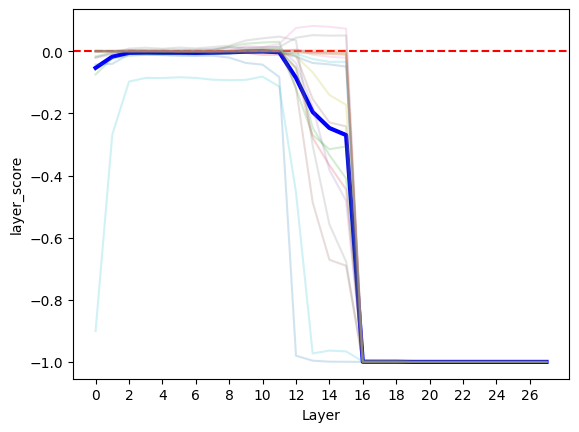

In [96]:
mean = [causal_tracing_results[layer].mean() for layer in models.determine_layer_paths(mt)]
# low = [causal_tracing_results[layer].min() for layer in mt.layer_names]
# high = [causal_tracing_results[layer].max() for layer in mt.layer_names]

plt.plot(mean, color="blue", linewidth=3)
# plt.fill_between(range(len(mean)), low, high, alpha=0.2)
plt.axhline(0, color="red", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("layer_score")
plt.xticks(models.determine_layers(mt)[::2])

for run in range(n_runs):
    arr = []
    for layer in models.determine_layer_paths(mt):
        arr.append(causal_tracing_results[layer][run])
    plt.plot(arr, alpha=0.2)


plt.show()

## Layer sweep on mean ICL

In [ ]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [ ]:
indices = np.random.choice(range(len(cur_relation_known.samples)), 2, replace=False)
samples = [cur_relation_known.samples[i] for i in indices]

capital_cities_subset = copy.deepcopy(cur_relation.__dict__)
capital_cities_subset["samples"] = samples
capital_cities_subset = data.Relation(**capital_cities_subset)

len(capital_cities_subset.samples)

In [ ]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=12,
)

operator = mean_estimator(capital_cities_subset)

In [ ]:
operator("Chile", k = 10).predictions

In [ ]:
predictions = []
target = []

for sample in tqdm(set(cur_relation_known.samples)):
    cur_predictions = operator(sample.subject, k = 5).predictions
    predictions.append([
        p.token for p in cur_predictions
    ])
    target.append(sample.object)

In [ ]:
from src.metrics import recall

recall(predictions, target)

In [ ]:
# np.savez("layer_sweep/operator_weight.npz", jacobian = operator.weight.detach().cpu().numpy(), allow_pickle=True)

In [ ]:
# j = np.load("layer_sweep/operator_weight.npz", allow_pickle=True)["jacobian"]

In [ ]:
# torch.dist(torch.tensor(j).to(device), operator.weight)

In [ ]:
def get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True):

    layer_wise_recall = {}

    layer_names = models.determine_layer_paths(mt)
    for h_layer in tqdm(range(0, 24)):
        layer_name = layer_names[h_layer]
        mean_estimator = JacobianIclMeanEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = mean_estimator(capital_cities_subset)
        if(save_weights):
            np.savez(
                f"layer_sweep/weights_and_biases/{layer_name}.npz", 
                jacobian = operator.weight.detach().cpu().numpy(),
                bias = operator.bias.detach().cpu().numpy(), 
                allow_pickle=True
            )

        predictions = []
        target = []

        for sample in set(cur_relation_known.samples) - set(capital_cities_subset.samples):
            cur_predictions = operator(sample.subject, k = 5).predictions
            predictions.append([
                p.token for p in cur_predictions
            ])
            target.append(sample.object)

        layer_wise_recall[layer_name] = recall(predictions, target)
        
        if(verbose):
            print(layer_name, layer_wise_recall[layer_name])
    
    return layer_wise_recall

layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True)

In [ ]:
with open("layer_sweep/layer_wise_recall.json", "w") as f:
    json.dump(layer_wise_recall, f)

In [ ]:
layer_wise_recall_collection = {}
number_of_runs = 10

for run in tqdm(range(number_of_runs)):
    indices = np.random.choice(range(len(cur_relation_known.samples)), 2, replace=False)
    samples = [cur_relation_known.samples[i] for i in indices]

    capital_cities_subset = copy.deepcopy(cur_relation.__dict__)
    capital_cities_subset["samples"] = samples
    capital_cities_subset = data.Relation(**capital_cities_subset)

    layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose=False, save_weights=False)

    for layer in layer_wise_recall.keys():
        if(layer not in layer_wise_recall_collection):
            layer_wise_recall_collection[layer] = []
        layer_wise_recall_collection[layer].append(layer_wise_recall[layer])

In [ ]:
with open("layer_sweep/layer_wise_recall_collection.json", "w") as f:
    json.dump(layer_wise_recall_collection, f)

In [ ]:
with open("layer_sweep/layer_wise_recall_collection.json") as f:
    layer_wise_recall_collection = json.load(f)

In [ ]:
# top_1 = [layer_wise_recall[layer][0] for layer in layer_wise_recall.keys()]
# top_2 = [layer_wise_recall[layer][1] for layer in layer_wise_recall.keys()]
# top_3 = [layer_wise_recall[layer][2] for layer in layer_wise_recall.keys()]

import numpy as np

top_1 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 0]
    for layer in layer_wise_recall_collection.keys()
])

top_2 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 1]
    for layer in layer_wise_recall_collection.keys()
])

top_3 = np.array([
    np.array(layer_wise_recall_collection[layer])[:, 2]
    for layer in layer_wise_recall_collection.keys()
])


plt.plot(top_1.mean(axis=1), color="green", linewidth=3, label="recall@1")
plt.plot(top_2.mean(axis=1), color="blue", linewidth=2, label="recall@2")
plt.plot(top_3.mean(axis=1), color="red", linewidth=1, label="recall@3")

plt.fill_between(
    range(len(layer_wise_recall_collection.keys())),
    top_1.min(axis=1), top_1.max(axis=1),
    color="green", alpha=0.1
)

plt.fill_between(
    range(len(layer_wise_recall_collection.keys())),
    top_2.min(axis=1), top_2.max(axis=1),
    color="blue", alpha=0.05
)

plt.fill_between(
    range(len(layer_wise_recall_collection.keys())),
    top_3.min(axis=1), top_3.max(axis=1),
    color="red", alpha=0.03
)


plt.xticks(range(0, len(top_1), 2))
plt.xlabel("layer")
plt.ylabel("recall")

plt.legend()
plt.show()

In [ ]:
from src.utils.supplimentary import visualize_matrix

for layer_name in models.determine_layer_paths(mt)[:24]:
    j = np.load(f"layer_sweep/weights_and_biases/{layer_name}.npz", allow_pickle=True)["jacobian"]
    j = torch.tensor(j).to(device)
    print(layer_name, j.shape)
    visualize_matrix(j, title = layer_name, save_path=f"layer_sweep/Jacobian_plots/{layer_name}.png")